# Project 1. 중고차 시세 예측
**과목명:  응용데이터애널리틱스 (Applied Data Analytics)** \\
**학수번호:  INE4108** \\
**교강사:  송재욱 교수 (산업공학과)** \\
 \\
***

## P1-1. Environmental Set-up & Data Loading

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# # enter the foldername in your Google Drive where you have saved the unzipped
# FOLDERNAME =  'ADX/'

# assert FOLDERNAME is not None, 'ERROR'

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../

# 한글 나눔포트 사용
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Mounted at /content/drive
/content/drive/My Drive
cp: missing destination file operand after '../../'
Try 'cp --help' for more information.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (6,622 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
import pandas as pd
import numpy as np
from time import time
import datetime
import math

from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic')

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [ ]:

# 모델 수립을 위한 Train/Validation Set
df = pd.read_csv('./ADX/Data_UsedCarPrediction/P1_dataset.csv', encoding ='cp949')  # 한글 Encoding 문제로 encoding = 'cp949'

# 시스템 구현을 위한 Test Set 샘플
df_test = pd.read_csv('./ADX/Data_UsedCarPrediction/P1_testset_sample.csv', encoding ='cp949')  # 한글 Encoding 문제로 encoding = 'cp949'

In [ ]:
df.head()

,GOODNO,SUCCYMD,CARNM,CHASNO,CARREGIYMD,YEAR,MISSNM,FUELNM,COLOR,EXHA,TRAVDIST,USEUSENM,OWNECLASNM,INNEEXPOCLASCD_YN,NEWCARPRIC,SUCCPRIC,YEARCHK,BONET,FRONT_LEFT_FENDER,FRONT_RIGHT_FENDER,FRONT_LEFT_DOOR,FRONT_RIGHT_DOOR,BACK_LEFT_DOOR,BACK_RIGHT_DOOR,TRUNK,FRONT_PANNEL,LEFT_STEP,RIGHT_STEP,LEFT_FILER_A,RIGHT_FILER_A,LEFT_FILER_B,RIGHT_FILER_B,LEFT_FILER_C,RIGHT_FILER_C,LEFT_REAR_FENDER,RIGHT_REAR_FENDER,BACK_PANEL1,LEFT_INSIDE_PANEL,RIGHT_INSIDE_PANEL,LEFT_WHEEL_HOUSE,...,LEFT_WHEEL_HOUSE_SHEETING,RIGHT_WHEEL_HOUSE_SHEETING,LEFT_REAR_INSIDE_PANEL_SHEETING,RIGHT_REAR_INSIDE_PANEL_SHEETING,LEFT_REAR_WHEEL_HOUSE_SHEETING,RIGHT_REAR_WHEEL_HOUSE_SHEETING,TRUNK_FLOOR_SHEETING,DASH_PANEL_SHEETING,SHEET_BACK_PANEL_SHEETING,SIDE_MEMBER_FRAME_SHEETING,FLOOR_PANEL_SHEETING,LEFT_SIDE_PANEL_SHEETING,RIGHT_SIDE_PANEL_SHEETING,FLOODING,TOTAL_LOSS,JOINCAR,NOTAVAILABLE,MF_KEY,MJ_MODEL_KEY,DT_MODEL_KEY,MJ_GRADE_KEY,DT_GRADE_KEY,NC_GRADE_KEY,SHIPPING_PRICE,NC_GRADE_PRICE,ABS,AB2,NAVIGATION,VDC,SMARTKEY,SUNLOOPPANORAMA,SUNLOOPCOMMON,SUNLOOPDUAL,DIS,TCS,AB1,ETC,AV,EPS,ECS
0,1512A2469,20160105,모닝 LPi LX 기본 블랙 프리미엄,KNABK518BBT020038,20100616.0,2011,A/T,LPG,C,1000,38480,자가,법인,X,10704916,4300000,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,46,28,158,18054,5192,11310000.0,9490000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1512A2364,20160105,K3 1.6 가솔린(4도어) Nobless,KNAFZ412BDA040155,20130207.0,2013,A/T,가솔린,A,1600,62240,자가,법인,X,21230000,11650000,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,37,295,1241,21541,13750,NaN,19750000.0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0
2,1512A2319,20160105,K3 1.6 가솔린(4도어) Trendy,KNAFK412BEA206484,20140128.0,2014,A/T,가솔린,A,1591,37926,자가,법인,X,18043152,12350000,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,37,295,1241,21538,17225,19340000.0,18170000.0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0
3,1512A1643,20160105,K5 2.0LPI 렌터카 디럭스,KNAGN418BDA366086,20121218.0,2013,A/T,LPG,B,2000,110149,렌트,법인,X,17280000,5900000,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,38,166,5782,20503,10890,17680000.0,17680000.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1512A1371,20160105,K5 2.0LPI 렌터카 스마트,KNAGN415BBA140279,20110428.0,2011,A/T,LPG,D,2000,81675,렌트,법인,X,15800000,4730000,Y,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2,38,166,5782,20502,5405,15800000.0,15800000.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(36794, 104)

In [ ]:
for col in df.columns:
  val=df[col].isnull().sum()
  if val>0:
    print(col,df[col].isnull().sum())

CARREGIYMD 1
FUELNM 1
USEUSENM 323
OWNECLASNM 13
SHIPPING_PRICE 4325
NC_GRADE_PRICE 3781


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


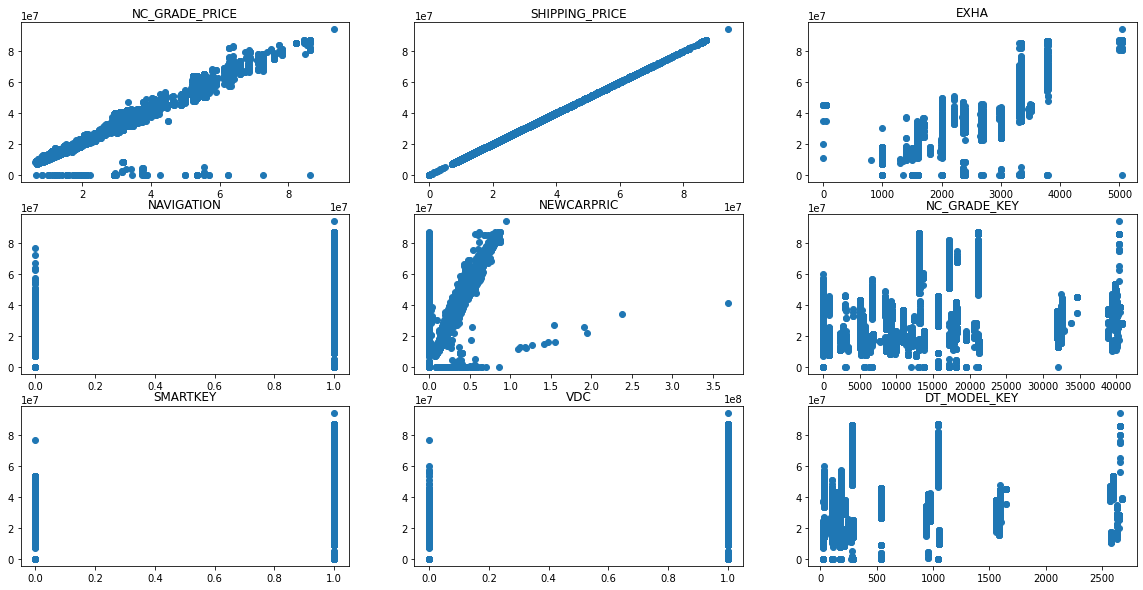

In [ ]:
df_view=df[['NC_GRADE_PRICE','SHIPPING_PRICE','EXHA','NAVIGATION','NEWCARPRIC','NC_GRADE_KEY','SMARTKEY','VDC','DT_MODEL_KEY']]
plt.figure(figsize=(20,10))
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.scatter(df_view.iloc[:,i], df_view['SHIPPING_PRICE'])
    plt.title(df_view.columns[i])

## P1-2. Modelling
- df를 사용하여 예측모형 수립
- 상세 사항은 업로드 된 비디오 참고

In [ ]:
def preprocessing_EXHA(df):
    return_df = df.copy()
    # EXHA 결측값 제거
    return_df["FUELNM"] = return_df["FUELNM"].fillna("global")
    exha_dict = dict(return_df["EXHA"].groupby(return_df["FUELNM"]).mean())
    exha_dict["global"] = return_df["EXHA"].mean()
    return_df["EXHA_ADJ"] = return_df.apply(lambda x: exha_dict[x["FUELNM"]]  if x["EXHA"] < 10 or np.isnan(x["EXHA"]) else x["EXHA"], axis=1) 
    return return_df
df_1 = preprocessing_EXHA(df)

return_df = df_1.copy()
price_list = []
return_df["EXHA_THOUSAND"] = return_df["EXHA_ADJ"].apply(lambda x: (x-1)//1000)  

def preprocessing_PRICE(df):
    return_df = df.copy()
    price_list = []
    return_df["EXHA_THOUSAND"] = return_df["EXHA_ADJ"].apply(lambda x: (x-1)//1000)    
    exha_dict = dict(return_df["SHIPPING_PRICE"].groupby(return_df["EXHA_THOUSAND"]).mean().round())
    global_mean = return_df["SHIPPING_PRICE"].mean()

    for shipping_price, nc_grade_price, new_car_price, exha_thousand in return_df[["SHIPPING_PRICE", "NC_GRADE_PRICE", "NEWCARPRIC", "EXHA_THOUSAND"]].values:
        if np.isnan(shipping_price) or shipping_price < 1e6:
            if np.isnan(nc_grade_price) or nc_grade_price < 1e6:
                if np.isnan(new_car_price) or new_car_price < 1e6:
                    if np.isnan(exha_dict[exha_thousand]) or exha_dict[exha_thousand] < 1e6:
                        val = global_mean
                    else:
                        val = exha_dict[exha_thousand]
                else:
                    val = new_car_price
                price_list.append(val)
            else:
                price_list.append(nc_grade_price)
        else:
            price_list.append(shipping_price) 

    return_df['PRICE'] = price_list
    return return_df

df_2 = preprocessing_PRICE(df_1)

In [ ]:
####
def preprocessing_year(df):
    return_df = df.copy()
    return_df['YEAR_adj'] = return_df.apply(lambda x: 0 if np.isnan(x['SUCCYMD']) or np.isnan(x['YEAR']) else int(str(x['SUCCYMD'])[:4])-x['YEAR'] , axis=1)
    #평균 주행거리 TRA_YEAR
    return_df['TRA_YEAR'] = return_df.apply(lambda x: 0 if np.isnan(x['TRAVDIST']) or x['YEAR_adj']==0  else x['TRAVDIST']/x['YEAR_adj'], axis=1)
    TRAV_AVG = return_df['TRA_YEAR'].mean()
    return_df['TRAVDIST'] = return_df.apply(lambda x: TRAV_AVG*x['YEAR_adj'] if np.isnan(x['TRAVDIST']) else x['TRAVDIST'], axis=1)
    return return_df

df_3 = preprocessing_year(df_2)

In [ ]:
#####
# string -> int
def preprocessing_string(df):
    return_df = df.copy()
    string_dict = {}
    string_col_list = []
    for col in df.columns:
        if df[col].dtypes == object:
            string_col_list.append(col)
    for col in string_col_list:
        string_dict[col] = {}
        count = 0
        for val in df[col].values:
            if val not in string_dict[col]:
                count += 1
                string_dict[col][val] = count
    for col in string_col_list:
        return_df[col] = return_df[col].apply(lambda x: string_dict[col][x])
    return return_df, string_col_list

df_4, string_col_list = preprocessing_string(df_3)
####

In [ ]:
#####
def preprocessing(df):
    df = preprocessing_EXHA(df)
    df = preprocessing_PRICE(df)
    df = preprocessing_year(df)
    df, string_col_list = preprocessing_string(df)
    return df, string_col_list

#####

In [ ]:
def make_train_val(df, use_x_col_list):
    def splitData(df, ratio, y_column):        
        columns_ = df.columns
        # Subsample the data
        mask = list(range(0,df.shape[0], ratio))
        X_val = df.iloc[mask, :].drop(y_column, 1)
        y_val = df.iloc[mask][y_column]
        
        mask = ~df.index.isin(mask)
        X_train = df.loc[mask, :].drop(y_column, 1)
        y_train = df.loc[mask, y_column]
        
        return X_train, y_train, X_val, y_val

    def z_normalize(_df, col_list):
        df = _df.copy()
        cache_dict = {}
        for col in col_list:
            cache_dict[col] = {"mean": df[col].mean(), "std": df[col].std()}
            if cache_dict[col]["std"] == 0:
                cache_dict[col]["std"] = 1
            df[col] = (df[col] - cache_dict[col]["mean"])/cache_dict[col]["std"]
        return df, cache_dict

    def z_normalize_val(_df, col_list, cache_dict):
        df = _df.copy()
        for col in col_list:
            df[col] = (df[col] - cache_dict[col]["mean"])/cache_dict[col]["std"]
        return df

    preprocessed_df = df.copy()
    X_train, y_train, X_val, y_val = splitData(preprocessed_df, 5, y_column = 'SUCCPRIC') 
    X_train_norm, cache = z_normalize(X_train, use_x_col_list)
    X_val_norm=z_normalize_val(X_val, use_x_col_list, cache)
    print("maked train, validate data set")

    return X_train_norm, y_train, X_val_norm, y_val

def make_best_rf(X_train_norm, y_train, X_val_norm, y_val):
    best_rf = None  
    best_mse = 1e20
    best_hyperparameter = None
    results = {}
    n_estimators = [5, 50, 100]
    max_depths = [5, 50, 100]
    ects = None

    for max_depth in max_depths:
        for  n_estimator in n_estimators:
            regressor = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimator, random_state=0)
            rf = regressor.fit(X_train_norm, y_train)
            y_pred = rf.predict(X_val_norm)
            mse = metrics.mean_squared_error(y_val, y_pred)
            results[(max_depth, n_estimator)] = mse
            print("max_depth: {} n_estimator: {} mse: {}".format(max_depth, n_estimator, mse))
            if mse < best_mse:
                best_mse = mse
                best_rf = rf
                best_hyperparameter = {"max_depth": max_depth, "n_estimator": n_estimator}
    print(best_hyperparameter)
    return best_rf


####

In [ ]:
def plot_feature_importance(importance_, features_,model_type):
    dict_ = {'feature importance' : importance_, 'features' : features_}
    df = pd.DataFrame(dict_)
    df.sort_values(by=['feature importance'], ascending=False,inplace=True)
    plt.figure(figsize=(10,10))
    sns.barplot(x=df['feature importance'], y=df['features'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

#plot_feature_importance(regressor.feature_importances_, X_val.columns, 'RANDOM FOREST ')

def print_feature_importance(best_rf, X_val_norm):
    imp=[]
    for importance, feature in zip(best_rf.feature_importances_, X_val_norm.columns):
        imp.append((importance, feature))
    imp_sorted=sorted(imp)
    for importance, feature in imp_sorted:
        print(importance, feature)
####

In [ ]:
# coninuos variable
"""
배기량, 가격 3종류 / 연식, 낙찰일자 / 주행거리/
"""
pd.set_option('display.max_rows', 200)

preprocessed_df = df_4.copy()
cor_df = preprocessed_df.corr()['SUCCPRIC']
cor_df = cor_df.dropna()
cor_df_abs = cor_df.abs()
print(cor_df_abs.sort_values()[-11:-1])

#####

SMARTKEY          0.554634
NC_GRADE_KEY      0.555709
NEWCARPRIC        0.557717
NAVIGATION        0.642113
EXHA              0.647280
EXHA_ADJ          0.647421
EXHA_THOUSAND     0.674328
SHIPPING_PRICE    0.789307
PRICE             0.796212
NC_GRADE_PRICE    0.803174
Name: SUCCPRIC, dtype: float64


In [ ]:
#-------------------------연속형변수만 랜덤포레스트
train_y_list = ["SUCCPRIC"]
numeric_col_list = []
temp_string_col_dict = {}
for col in string_col_list:
    temp_string_col_dict[col] = True

for col in preprocessed_df.columns:
    if col not in temp_string_col_dict:
        if col != "SUCCPRIC":
            numeric_col_list.append(col)
    
print(numeric_col_list)
numeric_preprocessed_df = preprocessed_df[numeric_col_list+train_y_list] 
temp_numeric_df = numeric_preprocessed_df.copy().dropna()
X_train_norm, y_train, X_val_norm, y_val = make_train_val(temp_numeric_df, numeric_col_list)
start = time()
best_rf = make_best_rf(X_train_norm, y_train, X_val_norm, y_val)
print("time: ", time()-start, "s")

print_feature_importance(best_rf, X_val_norm)

#####

['SUCCYMD', 'CARREGIYMD', 'YEAR', 'EXHA', 'TRAVDIST', 'NEWCARPRIC', 'BONET', 'FRONT_LEFT_FENDER', 'FRONT_RIGHT_FENDER', 'FRONT_LEFT_DOOR', 'FRONT_RIGHT_DOOR', 'BACK_LEFT_DOOR', 'BACK_RIGHT_DOOR', 'TRUNK', 'FRONT_PANNEL', 'LEFT_STEP', 'RIGHT_STEP', 'LEFT_FILER_A', 'RIGHT_FILER_A', 'LEFT_FILER_B', 'RIGHT_FILER_B', 'LEFT_FILER_C', 'RIGHT_FILER_C', 'LEFT_REAR_FENDER', 'RIGHT_REAR_FENDER', 'BACK_PANEL1', 'LEFT_INSIDE_PANEL', 'RIGHT_INSIDE_PANEL', 'LEFT_WHEEL_HOUSE', 'RIGHT_WHEEL_HOUSE', 'LEFT_INSIDE_WHEEL_HOUSE', 'RIGHT_INSIDE_WHEEL_HOUSE', 'LEFT_REAR_WHEEL_HOUSE', 'RIGHT_REAR_WHEEL_HOUSE', 'TRUNK_FLOOR', 'DASH_PANEL', 'SHEET_PANEL', 'SIDE_MEMBER_FRAME', 'LEFT_QUARTER', 'RIGHT_QUARTER', 'FLOOR_PANEL', 'LEFT_SIDE_PANEL', 'RIGHT_SIDE_PANEL', 'LEFT_REAR_CORNER_PANEL', 'RIGHT_REAR_CORNER_PANEL', 'BACK_PANEL2', 'LEFT_CORNER_PANEL', 'RIGHT_CORNER_PANEL', 'LEFT_SKIRT_PANEL', 'RIGHT_SKIRT_PANEL', 'SIDE_MEMBER_FRAME2', 'LEFT_INSIDE_SHEETING', 'RIGHT_INSIDE_SHEETING', 'LEFT_WHEEL_HOUSE_SHEETING', 'RI

In [ ]:
# string variable select: RF important 계산
"""
연료명, 차량명, 색, 용도
"""
for col in string_col_list:
    print(col, len(df_3[col].value_counts()), df_3.shape[0])

#####

GOODNO 36794 36794
CARNM 569 36794
CHASNO 36576 36794
MISSNM 3 36794
FUELNM 7 36794
COLOR 5 36794
USEUSENM 5 36794
OWNECLASNM 7 36794
INNEEXPOCLASCD_YN 2 36794
YEARCHK 2 36794


In [ ]:
string_preprocessed_df = preprocessed_df[string_col_list+train_y_list] 
temp_string_df = string_preprocessed_df.copy().dropna()
X_train_norm, y_train, X_val_norm, y_val = make_train_val(temp_string_df, string_col_list)
start = time()
best_rf = make_best_rf(X_train_norm, y_train, X_val_norm, y_val)
print("time: ", time()-start, "s")

print_feature_importance(best_rf, X_val_norm)

maked train, validate data set
max_depth: 5 n_estimator: 5 mse: 24085079275027.992
max_depth: 5 n_estimator: 50 mse: 24038822586206.465
max_depth: 5 n_estimator: 100 mse: 24011203175443.9
max_depth: 50 n_estimator: 5 mse: 6994630697649.137
max_depth: 50 n_estimator: 50 mse: 6112356177686.751
max_depth: 50 n_estimator: 100 mse: 6105614099219.716
max_depth: 100 n_estimator: 5 mse: 6994630697649.137
max_depth: 100 n_estimator: 50 mse: 6106218162076.369
max_depth: 100 n_estimator: 100 mse: 6101904313848.349
{'max_depth': 100, 'n_estimator': 100}
time:  40.06651949882507 s
0.002195445822346026 MISSNM
0.006259602693518382 INNEEXPOCLASCD_YN
0.006930068900474154 OWNECLASNM
0.012445608210680947 YEARCHK
0.05624475853787251 CHASNO
0.061094269203920026 GOODNO
0.08294218363765497 FUELNM
0.09344050873802873 USEUSENM
0.15064497757222756 COLOR
0.5278025766832767 CARNM


In [ ]:
# 최종 select된 변수로 RF 실행
use_numeric_list = ["PRICE", "EXHA_ADJ","TRAVDIST", "YEAR_adj"]
use_string_list = ["CARNM", "COLOR", "USEUSENM", "FUELNM"]
use_x_list = use_numeric_list + use_string_list

final_preprocessed_df = preprocessed_df[use_x_list+train_y_list]
X_train_norm, y_train, X_val_norm, y_val = make_train_val(final_preprocessed_df, use_x_list)
start = time()
best_rf = make_best_rf(X_train_norm, y_train, X_val_norm, y_val)
print("time: ", time()-start, "s")

#####

maked train, validate data set
max_depth: 5 n_estimator: 5 mse: 4324104294252.297
max_depth: 5 n_estimator: 50 mse: 3957897589863.8716
max_depth: 5 n_estimator: 100 mse: 3926245800645.499
max_depth: 50 n_estimator: 5 mse: 1423134652266.3103
max_depth: 50 n_estimator: 50 mse: 1222195789198.194
max_depth: 50 n_estimator: 100 mse: 1204972957070.4187
max_depth: 100 n_estimator: 5 mse: 1423134652266.3103
max_depth: 100 n_estimator: 50 mse: 1222195789198.194
max_depth: 100 n_estimator: 100 mse: 1204972957070.4187
{'max_depth': 50, 'n_estimator': 100}
time:  36.666653871536255 s


Train RMSE:  413263.9363462443
Train MAPE:  4.21667961508317
Validation RMSE:  1097712.6022190046
Validation MAPE:  10.928127597482854


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


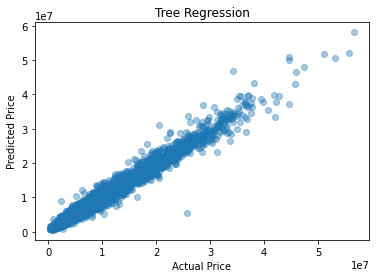

In [ ]:
def mape(y_pred, y_true ): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def rmse(y_pred, y_true):
    return np.sqrt(np.mean(np.square(y_pred- y_true)))

y_train_pred = best_rf.predict(X_train_norm)
print('Train RMSE: ', rmse(y_train_pred, y_train))
print('Train MAPE: ', mape(y_train_pred, y_train))
y_val_pred = best_rf.predict(X_val_norm)
print('Validation RMSE: ', rmse(y_val_pred, y_val))
print('Validation MAPE: ', mape(y_val_pred, y_val))

y_val_pred=best_rf.predict(X_val_norm)
plt.scatter(y_val, y_val_pred, alpha=0.4)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Tree Regression')
plt.show()

## P1-3. System Implementation
- df_test에 기반하여 실제 사용을 위한 system implemetation 작업 진행

In [ ]:
# test 처리
# df_test 에서 true y를 제거후에도 전처리가 잘 작동하는지 확인해봄
df_test_drop = df_test.drop(["SUCCPRIC"], axis=1)
preprocesed_df_test, string_col_list = preprocessing(df_test_drop)
use_numeric_list = ["PRICE", "EXHA_ADJ","TRAVDIST", "YEAR_adj"]
use_string_list = ["CARNM", "COLOR", "USEUSENM", "FUELNM"]
use_x_list = use_numeric_list + use_string_list
input_x = preprocesed_df_test[use_x_list]

pred_y = best_rf.predict(input_x)
for idx, pred_val in enumerate(pred_y):
  print("{} 번 중고차 시세 예측 가격은: {}입니다".format(idx, pred_val))

[ 938800.  938800.  938800. 1082900. 1047900. 1056700. 1056700. 1056700.
 1137900. 1056700. 1137900. 1137900. 1137900. 1137900. 1137900. 1137900.
 1137900. 1100100.  944200. 1094600.]
